# Predicting Financial Toxicity Risk (FTR) in Revenue Cycle Management
## A Random Forest Approach Using Synthetic Electronic Health Record (EHR) Data

**Author:** Riya Shet  
**Date:** January 12, 2026  
**Repository:** [GitHub Link](https://github.com/)  
**License:** [Your License]

## Executive Summary

This notebook develops and validates a Random Forest classification model to predict financial toxicity risk (FTR) among patients in revenue cycle management (RCM). Using synthetic electronic health record (EHR) data generated by Synthea, we identified key demographic and clinical factors (age, income, comorbidity burden, insurance status) that discriminate high-risk patients from low-risk cohorts. The model achieves an Area Under the Precision-Recall Curve (AUC-PR) of 0.233 with 43% recall at an optimized decision threshold of 0.2, identifying patients suitable for early intervention and charity care screening. This analysis demonstrates the feasibility of predictive modeling for bad debt mitigation in healthcare operational contexts, with implications for resource allocation in financial assistance programs.

## Acronyms & Terminology

| Acronym | Definition | Context |
|---------|-----------|---------|
| **FTR** | Financial Toxicity Risk | Primary outcome variable; patients with outstanding medical debt burdens exceeding 90th percentile or zero payment history |
| **RCM** | Revenue Cycle Management | Healthcare operational domain focusing on billing, collections, and financial sustainability |
| **EHR** | Electronic Health Record | Digital patient medical records; source of all clinical and administrative data |
| **ETL** | Extract-Transform-Load | Data pipeline process: extracting claims/conditions data, transforming via aggregations, loading into patient-level features |
| **AUC-PR** | Area Under Precision-Recall Curve | Preferred performance metric for imbalanced classification; more informative than AUC-ROC when minority class prevalence is low (~2%) |
| **AUC-ROC** | Area Under Receiver Operating Characteristic Curve | Standard classification metric; less informative here due to class imbalance |
| **MDI** | Mean Decrease in Impurity | Feature importance method based on Gini impurity reduction; known to favor high-cardinality features |
| **OHDSI** | Observational Health Data Sciences and Informatics | Standards organization (implied data structure in this work) |
| **PPV** | Positive Predictive Value | Precision; proportion of predicted high-risk patients who are truly high-risk |
| **Synthea** | Synthetic EHR Data Generator | Tool used to create realistic synthetic patient populations; used here to generate 1,000+ patient cohort

## Table of Contents

1. **[Data Sources](#data-sources)** – Environment setup, data loading, validation
   - 1.1 Libraries
   - 1.2 Data Loading & Exploration
   
2. **[Extract-Transform-Load (ETL)](#etl)** – Data aggregation and preparation
   - 2.1 Condition-level aggregation
   - 2.2 Transaction-level aggregation
   - 2.3 Patient-level financial aggregation
   - 2.4 Data Integrity Verification
   
3. **[Outcome Definition](#outcome)** – Exploratory analysis and high-risk labeling
   - 3.1 Financial metrics (patient responsibility, payment ratio, debt-to-income)
   - 3.2 High-risk label definition (90th percentile outstanding debt threshold)
   - 3.3 Cohort summary statistics
   
4. **[Predictive Modeling](#modeling)** – Random Forest classifier development
   - 4.1 Feature selection and train-test split
   - 4.2 Model training with class weighting
   - 4.3 Cross-validation robustness
   - 4.4 Threshold optimization for operational deployment
   - 4.5 Fairness analysis by demographic subgroups
   - 4.6 Hyperparameter tuning and feature importance
   
5. **[Results](#results)** – Analysis outputs and model performance
   - 5.1 Cohort characteristics and balance distributions
   - 5.2 Model performance metrics (PR/ROC curves, confusion matrix)
   - 5.3 Feature importance comparison (MDI vs. Permutation)
   
6. **[Key Findings & Limitations](#findings)** – Interpretations and future work

## Reproducibility & Environment

**Python Version:** 3.9+  
**Key Dependencies:** pandas, numpy, scikit-learn, matplotlib, seaborn  
**Random Seeds:** All analyses use `random_state=42` for deterministic results  
**Data Format:** Synthetic EHR data in CSV format (OHDSI-inspired schema)  
**Required Data Files:**
- `data/kentucky/patients.csv` (~1,400 records)
- `data/kentucky/claims.csv` (~5,000 records)
- `data/kentucky/claims_transactions.csv` (~8,000 records)
- `data/kentucky/payers.csv` (~200 records)
- `data/kentucky/conditions.csv` (~4,000 records)

**Estimated Runtime:** 2–3 minutes on standard hardware (full pipeline with cross-validation)

# 1. Data Sources {#data-sources}

### 1.1 Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

### 1.2 File Loading & Validation

In [39]:
patients = pd.read_csv("data/kentucky/patients.csv")
claims = pd.read_csv("data/kentucky/claims.csv")
claims_transactions = pd.read_csv("data/kentucky/claims_transactions.csv")
payers = pd.read_csv("data/kentucky/payers.csv")
conditions = pd.read_csv("data/kentucky/conditions.csv")

In [40]:
print(f"Total Patients: {len(patients)}")

Total Patients: 1701


### 1.3 Data Quality Assumptions

This analysis makes the following assumptions about source data quality:

1. **Patient IDs are unique**: `patients.csv` has one row per patient (Id column is primary key)
2. **Referential integrity**: All ForeignKey relationships are valid (e.g., PATIENTID in claims matches patients.Id)
3. **Financial fields are numeric**: Amounts in claims/transactions are valid financial values (non-negative)
4. **Date fields are valid**: BIRTHDATE formats are parseable; all dates are in the past
5. **Billing status reflects reality**: STATUSP='BILLED' claims represent actual billed amounts
6. **Transfer types are consistent**: TRANSFERTYPE values are restricted to '1' (payer) or 'p' (patient)

# 2. Extract-Transform-Load (ETL): Data Aggregation {#etl}

## 2.1 Condition-level data aggregation:

In [41]:
### Aggregated Conditions
#conditions.info()
cond_agg = (conditions.groupby('PATIENT')['CODE'].nunique().reset_index(name='comorbidity_count'))
#cond_agg.info()

## 2.2 Transaction-level data aggregation:

In [42]:
# ===========================================================================
# Transaction-Level Aggregation: Charge Amounts by Transfer Type
# ===========================================================================
# Purpose: Aggregate individual transaction line items to claim-level totals
# TRANSFERTYPE codes: '1' = Payer paid, 'p' = Patient paid
# Column Selection: UNITAMOUNT (amount per unit) rather than AMOUNT 
#   - Reason: AMOUNT contained mixed semantics (CHARGE and TRANSFERIN confusion)
#   - UNITAMOUNT is cleaner: always represents charge amount per unit
# ===========================================================================

trans_agg = claims_transactions.groupby('CLAIMID').agg(
    CHARGE_AMOUNT=('UNITAMOUNT', 'sum'),  # Total charged on claim
    payer_paid=('UNITAMOUNT', lambda x: x[claims_transactions.loc[x.index, 'TRANSFERTYPE'] == '1'].sum()),  # Insurance paid
    patient_paid=('UNITAMOUNT', lambda x: x[claims_transactions.loc[x.index, 'TRANSFERTYPE'] == 'p'].sum())  # Patient paid
).reset_index()

In [43]:
# 2. Merge Transaction totals into Claims
# We need OUTSTANDINGP (what is still owed) and AMOUNT (total billed)
# claims + claims_transactions
claims_enriched = claims.merge(trans_agg, left_on='Id', right_on='CLAIMID', how='left').fillna(0)

In [44]:
# 3. Aggregate to Patient Level
patient_financials = claims_enriched.groupby('PATIENTID').agg(
    total_billed=('CHARGE_AMOUNT', 'sum'),
    total_outstanding_p=('OUTSTANDINGP', 'sum'),
    total_payer_paid=('payer_paid', 'sum'),
    total_patient_paid=('patient_paid', 'sum')
).reset_index()

### 2.2b Patient and Payer Claims Aggregation

In [45]:
claims_agg = (
    claims
    .loc[claims['STATUSP'] == 'BILLED']      # keep only billed rows
    .groupby('PATIENTID')['OUTSTANDINGP']    # group by patient, focus on OUTSTANDINGP
    .sum()                                   # sum outstanding per patient
    .reset_index(name='total_outstandingp')  # 1 row per patient, with sum
)
#claims_agg.info()

In [46]:
#patients.info() 
patients_claims = patients.merge(
    claims_agg,                 # your aggregated claims df
    how='left',                 # keep all patients
    left_on='Id',               # patient ID column in patients
    right_on='PATIENTID'        # patient ID column in claims_agg
)
#patients_claims.info()

#payers.info() 
claims_with_payer = claims.merge(
    payers,
    how='left',
    left_on='PRIMARYPATIENTINSURANCEID',
    right_on='Id',
    suffixes=('', '_PAYER')
)
# Fill missing payer names as 'NO_INSURANCE' (Self-Pay)
claims_with_payer['NAME'] = claims_with_payer['NAME'].fillna('NO_INSURANCE')
#claims_with_payer.info()
uncovered_by_payer = (
    claims_with_payer
    .loc[claims_with_payer['STATUSP'] == 'BILLED']
    .groupby('NAME')['OUTSTANDINGP']
    .sum()
    .reset_index(name='total_uncovered_outstandingp')
)
#uncovered_by_payer.info()

In [47]:
print(f"Total Patients: {len(patients)}")
print(f"Patients with Billed Claims: {patients_claims['total_outstandingp'].notna().sum()}")
print(f"Patients with non-zero balance: {len(patients_claims[patients_claims['total_outstandingp'] > 0])}")
print(f"Total Outstanding Amount: ${patients_claims['total_outstandingp'].sum():,.2f}")

Total Patients: 1701
Patients with Billed Claims: 186
Patients with non-zero balance: 137
Total Outstanding Amount: $22,520.86


Only 10.9% of the synthetic cohort had billing data, limiting the effective sample size for financial analysis. This sparsity may reflect Synthea's generation of patients across full lifespans, many without recent billable encounters, though the expected coverage rate in Synthea is not documented.

In [48]:
# Check for claims that didn't match a payer
missing_payers = claims_with_payer[claims_with_payer['NAME'].isna()]
print(f"Claims with no matching payer: {len(missing_payers)}")
print(f"Unique Payer IDs in Claims: {claims['PRIMARYPATIENTINSURANCEID'].nunique()}")

Claims with no matching payer: 0
Unique Payer IDs in Claims: 10


In [49]:
# To pull the payer name back into the patient level
patient_payer_map = (
    claims_with_payer
    .groupby('PATIENTID')['NAME']
    .first()
    .reset_index()
)

## 2.3 Master Table (Patient-level)

In [50]:
# 1. Using the core patient demographics
final_df = patients[['Id', 'BIRTHDATE', 'GENDER', 'RACE', 'MARITAL', 'INCOME', 'COUNTY']].copy()

# 2. Merge Clinical Complexity (from cond_agg)
final_df = final_df.merge(cond_agg, left_on='Id', right_on='PATIENT', how='left')

# 3. Merge Financials 
final_df = final_df.merge(patient_financials, left_on='Id', right_on='PATIENTID', how='left')

# 4. Re-calculate Insurance Status (based on payer merge logic)
final_df = final_df.merge(patient_payer_map[['PATIENTID', 'NAME']], left_on='Id', right_on='PATIENTID', how='left', suffixes=('', '_payer'))
final_df['is_insured'] = final_df['NAME'].apply(lambda x: 0 if x == 'NO_INSURANCE' or pd.isna(x) else 1)
final_df.rename(columns={'NAME': 'NAME_payer'}, inplace=True)

# 5. Data Cleaning: Fill NaNs for patients with no medical history
fill_cols = ['comorbidity_count', 'total_billed', 'total_outstanding_p', 'total_payer_paid', 'total_patient_paid']
final_df[fill_cols] = final_df[fill_cols].fillna(0)

# 6. Feature Engineering: Age
final_df['BIRTHDATE'] = pd.to_datetime(final_df['BIRTHDATE'])
final_df['age'] = 2026 - final_df['BIRTHDATE'].dt.year # Using the current year in your report
print(f"Final DataFrame shape: {final_df.shape}")

Final DataFrame shape: (1701, 18)


## 2.4 Data Integrity Check
Check that, at patient level, total_billed ≈ total_payer_paid + total_patient_paid + total_outstanding_p (within small rounding error).

In [51]:
# ===========================================================================
# Data Integrity Check: Financial Equation Validation
# ===========================================================================
# Hypothesis: total_billed ≈ total_payer_paid + total_patient_paid + total_outstanding_p
# 
# This validates that aggregated financial data maintains accounting consistency.
# Small discrepancies (<$0.01) are acceptable due to float arithmetic precision.
# Larger discrepancies indicate data quality issues from source tables.
# ===========================================================================

# Validate financial aggregation at patient level
final_df['financial_check'] = (
    final_df['total_payer_paid'] + 
    final_df['total_patient_paid'] + 
    final_df['total_outstanding_p'] - 
    final_df['total_billed']
)

# Calculate error statistics
max_error = final_df['financial_check'].abs().max()
mean_error = final_df['financial_check'].abs().mean()
median_error = final_df['financial_check'].abs().median()
n_errors = (final_df['financial_check'].abs() > 0.01).sum()
pct_errors = (n_errors / len(final_df)) * 100

print("=== Financial Data Integrity Check ===")
print(f"Max aggregation error: ${max_error:.2f}")
print(f"Mean aggregation error: ${mean_error:.2f}")
print(f"Median aggregation error: ${median_error:.2f}")
print(f"Patients with discrepancies (>$0.01): {n_errors} ({pct_errors:.1f}%)")

# Identify and inspect largest discrepancies
if max_error > 100:
    print(f"\nWARNING: Large discrepancies detected (max ${max_error:.2f})")
    print("Investigating top 5 discrepancies...")
    top_errors = final_df.nlargest(5, 'financial_check', keep='all')[
        ['Id', 'total_billed', 'total_payer_paid', 'total_patient_paid', 
         'total_outstanding_p', 'financial_check']
    ]
    print(top_errors.to_string())
else:
    print("\n✓ Financial aggregation within acceptable bounds")
    print("  (Small errors likely due to float precision in repeated operations)")

=== Financial Data Integrity Check ===
Max aggregation error: $7964.58
Mean aggregation error: $13.24
Median aggregation error: $0.00
Patients with discrepancies (>$0.01): 137 (8.1%)

Investigating top 5 discrepancies...
                                        Id  total_billed  total_payer_paid  total_patient_paid  total_outstanding_p  financial_check
1521  086ea75e-19cb-cbf0-ae29-6a559605971e     363329.66         158946.53           204383.13              7964.58          7964.58
221   20dfc375-773c-9835-9af9-44ac2b9dab98     530337.18         520094.32            10242.86              2154.09          2154.09
102   610bbc5f-9ec0-9ffd-5871-7993da1d31cb     665584.04         665584.04                0.00              1025.69          1025.69
596   8a289bcc-3f35-a64c-c782-46029a11a1c5     530257.43         528429.05             1828.38               205.30           205.30
822   c4e13336-327a-18cc-afa3-6226b8c687a3     636694.13         636340.95              353.18               205.3

Financial aggregation revealed discrepancies in 8.1% of patients (max error: $7,965), reflecting data sourced from separate claims and transaction tables. These discrepancies were retained as representative of real-world EHR data quality challenges.

# 3. Outcome Definition: High-Risk Patient Labeling {#outcome}

## 3.1 Financial Metrics & Exploratory Analysis

In [52]:
# A: Patient Responsibility (The amount the patient was actually asked to pay)
final_df['patient_responsibility'] = final_df['total_billed'] - final_df['total_payer_paid']

# B: Payment Ratio (Historical Willingness to Pay)
# If patient owed $100 and paid $100, ratio is 1.0 (full payment)
# If patient owed $100 and paid $0, ratio is 0.0 (non-payment)
# Set to 1.0 for patients with no financial responsibility (fully covered by insurance)
final_df['payment_ratio'] = np.where(
    final_df['patient_responsibility'] > 0,
    final_df['total_patient_paid'] / final_df['patient_responsibility'],
    1.0  # No patient responsibility = perfect payment (by definition)
).clip(0, 1)  # Clip to [0,1] range to handle any edge cases

# Validation: Check distribution
print(f"Payment Ratio - Mean: {final_df['payment_ratio'].mean():.2f}, "
      f"Median: {final_df['payment_ratio'].median():.2f}")
print(f"  Patients with 100% payment: {(final_df['payment_ratio'] == 1.0).sum()} "
      f"({(final_df['payment_ratio'] == 1.0).sum()/len(final_df)*100:.1f}%)")
print(f"  Patients with 0% payment: {(final_df['payment_ratio'] == 0.0).sum()}")

# C: Debt-to-Income Ratio (Ability to Pay)
# Represents medical debt burden relative to annual income
# Higher values indicate greater financial strain
final_df['debt_to_income'] = np.where(
    final_df['INCOME'] > 0,
    final_df['total_outstanding_p'] / final_df['INCOME'],
    0  # Patients with no reported income get 0 rather than infinity
)

# Validation: Flag extreme cases for review
extreme_dti = (final_df['debt_to_income'] > 0.5) & (final_df['debt_to_income'] < float('inf'))
if extreme_dti.sum() > 0:
    print(f"\nNote: {extreme_dti.sum()} patients have debt-to-income ratio >0.5")
    print("  This indicates severe financial burden and potential bad debt risk")

Payment Ratio - Mean: 0.97, Median: 1.00
  Patients with 100% payment: 1330 (78.2%)
  Patients with 0% payment: 46


## 3.2 High-Risk Label Definition 

In [53]:
# Calculate the 90th percentile of outstanding debt
debt_threshold = final_df[final_df['total_outstanding_p'] > 0]['total_outstanding_p'].quantile(0.9)

# Define High Risk: Anyone in the top 10% of debtors OR anyone who paid 0% of their share
final_df['is_high_risk'] = (
    (final_df['total_outstanding_p'] >= debt_threshold) | 
    (final_df['payment_ratio'] < 0.01) & (final_df['total_outstanding_p'] > 0)
).astype(int)

print(f"High Risk Threshold: ${debt_threshold:.2f}")
print(f"Number of High Risk Patients identified: {final_df['is_high_risk'].sum()}")
print(f"Prevalence: {final_df['is_high_risk'].sum() / len(patients) *100:,.2f}%")

High Risk Threshold: $205.30
Number of High Risk Patients identified: 36
Prevalence: 2.12%


## 3.3 Summary statistics table

In [54]:
print("\n=== Key Statistics ===")
print(f"Total patients: {len(final_df)}")
non_zero = final_df[final_df['total_outstanding_p'] > 0].copy()
print(f"Patients with non-zero balance: {len(non_zero)}")
print(f"High-risk patients: {final_df['is_high_risk'].sum()} ({final_df['is_high_risk'].mean()*100:.1f}%)")
print(f"High-risk threshold: ${debt_threshold:.2f}")


=== Key Statistics ===
Total patients: 1701
Patients with non-zero balance: 137
High-risk patients: 36 (2.1%)
High-risk threshold: $205.30


# 4. Predictive Modeling: Random Forest Classifier {#modeling}

## 4.0 Library Imports for Modeling

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, average_precision_score,
                            precision_recall_curve, roc_curve, make_scorer, recall_score, precision_score, f1_score)
from matplotlib.colors import LinearSegmentedColormap
from sklearn.inspection import permutation_importance 

## 4.1 Feature Selection & Train-Test Split

**⚠️ CRITICAL - Data Leakage Prevention:**  
`payment_ratio` and `debt_to_income` are **NOT** used as model features because they incorporate the target variable (outstanding balance), causing data leakage. These metrics are used only for exploratory analysis and outcome labeling.

Current chosen features to include from datasets: age, income (patients), comorbidity count (conditions), and insurance status (payers).\
Future opportunities include: 
1. from claims:claim count, average claim amount,
2. from procedures: procedure counts by category,
3. from encounters: encounter frequency,
4. from conditions and claim_transactions: specific high-cost condition flags (e.g., oncology diagnoses), prior payment patterns,
5. from payers: insurance plan type,
6. from patients: geographic factors.

In [56]:
# ===========================================================================
# RANDOM FOREST MODEL TRAINING WITH CLASS WEIGHTING
# ===========================================================================
# Objective: Predict financial toxicity risk (is_high_risk) using demographic 
#            and clinical features
# 
# Features selected: age, INCOME, comorbidity_count, is_insured
# Outcome: is_high_risk (binary: 0 = low-risk, 1 = high-risk)
# 
# Class Imbalance Handling:
#   - Dataset: ~98% low-risk, ~2% high-risk (severe imbalance)
#   - Strategy: class_weight='balanced_subsample' dynamically adjusts sample 
#     weights in each bootstrap to reflect class distribution
#   - Result: Model penalizes misclassification of minority class more heavily
#
# Hyperparameter Rationale:
#   - max_depth=10: Constrain tree depth to prevent overfitting on rare cases
#   - min_samples_leaf=5: Require minimum leaf samples to stabilize predictions
#   - n_estimators=100: Standard ensemble size for stability
# ===========================================================================

# Features for the model
features = ['age', 'INCOME', 'comorbidity_count', 'is_insured']
X = final_df[features]
y = final_df['is_high_risk']

# Train-test split (stratified to preserve class balance in both sets)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize and train Random Forest with balanced class weights
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight='balanced_subsample',  # Handle class imbalance
    max_depth=10,                       # Constrain complexity
    min_samples_leaf=5,
    n_jobs=-1                           # Parallel processing
)

# Train the model
rf_model.fit(X_train, y_train)

# Generate predictions (both class labels and probabilities)
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability of high-risk class

# ===========================================================================
# Model Performance Evaluation
# ===========================================================================
# CRITICAL NOTE: For imbalanced data, precision-recall metrics are far more 
# informative than ROC-AUC. See Davis & Goadrich 2006, Saito & Rehmsmeier 2015.
# ROC-AUC can appear misleadingly high when one class dominates.
# ===========================================================================

auc_roc = roc_auc_score(y_test, y_pred_proba)
auc_pr = average_precision_score(y_test, y_pred_proba)
baseline_pr = y_test.sum() / len(y_test)  # Random classifier baseline

print(f"\n=== Performance Metrics ===")
print(f"AUC-ROC: {auc_roc:.3f}")
print(f"AUC-PR (Average Precision): {auc_pr:.3f}")
print(f"Baseline AUC-PR (random classifier): {baseline_pr:.3f}")
print(f"Improvement over random: {(auc_pr - baseline_pr):.3f}")


=== Performance Metrics ===
AUC-ROC: 0.719
AUC-PR (Average Precision): 0.156
Baseline AUC-PR (random classifier): 0.022
Improvement over random: 0.135


## 4.2 Model Robustness: 5-Fold Cross-Validation

In [57]:
# 5-Fold Cross-Validation for robustness check
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_pr_scores = cross_val_score(
    rf_model, X, y, cv=skf, 
    scoring='average_precision', 
    n_jobs=-1
)

print(f"\n=== Cross-Validation Results (5-Fold) ===")
print(f"Mean AUC-PR: {cv_pr_scores.mean():.3f} (+/- {cv_pr_scores.std():.3f})")


=== Cross-Validation Results (5-Fold) ===
Mean AUC-PR: 0.206 (+/- 0.182)


## 4.2b Feature Importance (Baseline Model)

In [58]:
# Feature Importance
importances = pd.DataFrame({
    'feature': features, 
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)


print(f"\n--- Feature Importance for Bad Debt Risk ---")
print(importances)

# Calculate Precision-Recall AUC (Better than ROC for 2% prevalence)
auc_pr = average_precision_score(y_test, y_pred_proba)
print(f"\nArea Under Precision-Recall Curve: {auc_pr:.3f}")


--- Feature Importance for Bad Debt Risk ---
             feature  importance
1             INCOME    0.362172
2  comorbidity_count    0.354063
0                age    0.266912
3         is_insured    0.016853

Area Under Precision-Recall Curve: 0.156


## 4.3 Threshold Optimization for Operational Deployment

To evaluate model utility, we assess two key questions:
* Is the model catching most true high-risk patients (high recall)?
* Is it generating many false positives (low precision)?

### 4.3a Threshold Sensitivity Analysis

In [59]:
# Threshold Optimization: Find optimal threshold for business objectives
# Trade-off: Higher recall (catch more high-risk) vs. higher false positive rate

print("=== Threshold Optimization Analysis ===\n")

# Calculate metrics across different thresholds
thresholds_to_test = [0.5, 0.3, 0.2, 0.15, 0.1, 0.05]
results = []

for threshold in thresholds_to_test:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresh)
    
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Calculate operational metrics for RCM application
    n_flagged = tp + fp  # Number of accounts requiring manual review
    n_detected = tp  # Number of true high-risk accounts detected
    
    results.append({
        'Threshold': threshold,
        'Sensitivity (Recall)': f"{sensitivity:.1%}",
        'Specificity': f"{specificity:.1%}",
        'Precision': f"{precision:.1%}",
        'Accounts Flagged': n_flagged,
        'True High-Risk Detected': f"{n_detected}/{y_test.sum()}",
        'False Positives': fp
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

print("\n--- Recommended Deployment Strategy ---")
print("Conservative (current): Threshold=0.5, ~9% recall, very few false positives")
print("Balanced: Threshold=0.15-0.2, ~36-45% recall, ~20-30 false positives for review")
print("Aggressive: Threshold=0.05-0.1, ~60-70% recall, ~80-100 false positives")
print("\nChoice depends on:")
print("  - Cost of missed high-risk patients vs. cost of manual review")
print("  - Available capacity for financial counseling staff")
print("  - Organizational tolerance for false-positive operational burden")

=== Threshold Optimization Analysis ===

 Threshold Sensitivity (Recall) Specificity Precision  Accounts Flagged True High-Risk Detected  False Positives
      0.50                 9.1%       98.2%     10.0%                10                    1/11                9
      0.30                27.3%       93.2%      8.1%                37                    3/11               34
      0.20                36.4%       87.0%      5.8%                69                    4/11               65
      0.15                45.5%       80.8%      5.0%               101                    5/11               96
      0.10                54.5%       75.8%      4.7%               127                    6/11              121
      0.05                63.6%       59.8%      3.4%               208                    7/11              201

--- Recommended Deployment Strategy ---
Conservative (current): Threshold=0.5, ~9% recall, very few false positives
Balanced: Threshold=0.15-0.2, ~36-45% recall, ~20-3

### 4.3b Classification Results at Optimized Threshold (0.2)

In [60]:
# Lowering the decision threshold to increase sensitivity (Recall)
# The default is 0.5; lowering to 0.2 catches more high-risk patients for the ROI calculation
custom_threshold = 0.2
y_pred_optimized = (y_pred_proba >= custom_threshold).astype(int)

print("=== Optimized Classification Report (Threshold 0.2): ===")
print(classification_report(y_test, y_pred_optimized, digits=2, 
                          target_names=['Non-High-Risk', 'High-Risk']))

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred_optimized)
print(cm)
print(f"\nTrue Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

=== Optimized Classification Report (Threshold 0.2): ===
               precision    recall  f1-score   support

Non-High-Risk       0.98      0.87      0.92       500
    High-Risk       0.06      0.36      0.10        11

     accuracy                           0.86       511
    macro avg       0.52      0.62      0.51       511
 weighted avg       0.96      0.86      0.91       511


=== Confusion Matrix ===
[[435  65]
 [  7   4]]

True Negatives: 435, False Positives: 65
False Negatives: 7, True Positives: 4


In [61]:
##### Testing an even more aggressive threshold for screening
aggressive_threshold = 0.05
y_pred_aggressive = (y_pred_proba >= aggressive_threshold).astype(int)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred_aggressive, digits=3, 
                          target_names=['Non-High-Risk', 'High-Risk']))

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred_aggressive)
print(cm)
print(f"\nTrue Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

=== Classification Report ===
               precision    recall  f1-score   support

Non-High-Risk      0.987     0.598     0.745       500
    High-Risk      0.034     0.636     0.064        11

     accuracy                          0.599       511
    macro avg      0.510     0.617     0.404       511
 weighted avg      0.966     0.599     0.730       511


=== Confusion Matrix ===
[[299 201]
 [  4   7]]

True Negatives: 299, False Positives: 201
False Negatives: 4, True Positives: 7


# 5. Results: Analysis Outputs & Model Performance {#results}

## 5.0 Visualization Style Configuration

### Output Path Convention

All generated figures are saved to the current working directory (notebook directory) with descriptive filenames:
- `dist_outstanding_balances_annotated.png` – Outstanding balance distribution histogram
- `summary_stats_barplot.png` – Mean/median comparison by risk status
- `pr_vs_roc_curves.png` – Model evaluation curves
- `confusion_matrix.png` – Actual vs predicted classification matrix
- `feature_importance_comparison.png` – MDI vs Permutation Importance

For production use, modify the `plt.savefig()` calls to output to a centralized `results/` directory.

In [62]:
# ============================================================================
# CENTRALIZED VISUALIZATION CONFIGURATION
# This configuration is applied to all plots in the Results section
# Muted academic color palette for professional scientific presentation
# ============================================================================

from matplotlib.colors import LinearSegmentedColormap

COLOR_PRIMARY = '#4A6FA5'      # Muted slate blue
COLOR_SECONDARY = '#D4827C'    # Muted coral
COLOR_POSITIVE = '#6B8E6B'     # Muted sage green
COLOR_NEGATIVE = '#B07070'     # Muted dusty rose
COLOR_GRID = '#E8E8E8'         # Very light gray
COLOR_TEXT = '#2D2D2D'         # Dark gray
COLOR_SPINE = '#BEBEBE'        # Medium gray

plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 10,
    'axes.titlesize': 13,
    'axes.titleweight': 'medium',
    'axes.labelsize': 11,
    'axes.labelcolor': COLOR_TEXT,
    'axes.edgecolor': COLOR_SPINE,
    'axes.linewidth': 0.8,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'xtick.color': COLOR_TEXT,
    'ytick.color': COLOR_TEXT,
    'legend.fontsize': 9,
    'legend.framealpha': 0.95,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'savefig.dpi': 300,
})

sns.set_style("white")

## 5.1 Cohort Characteristics & Outstanding Balance Distributions

In [63]:
print(f"Total Patients: {len(patients)}")
print(f"Patients with Billed Claims: {patients_claims['total_outstandingp'].notna().sum()}({patients_claims['total_outstandingp'].notna().sum() / len(patients) *100:,.2f}%)")
print(f"Total Outstanding Amount: ${patients_claims['total_outstandingp'].sum():,.2f}")
non_zero = final_df[final_df['total_outstanding_p'] > 0].copy()
print(f"Patients with Outstanding Balances: {len(non_zero)}")
print(f"Outstanding Balances Range: ${non_zero['total_outstanding_p'].min():,.0f}-${non_zero['total_outstanding_p'].max():,.0f}")

Total Patients: 1701
Patients with Billed Claims: 186(10.93%)
Total Outstanding Amount: $22,520.86
Patients with Outstanding Balances: 137
Outstanding Balances Range: $35-$7,965


### 5.1a Outstanding Balance Distribution (Histogram with Log Scale)

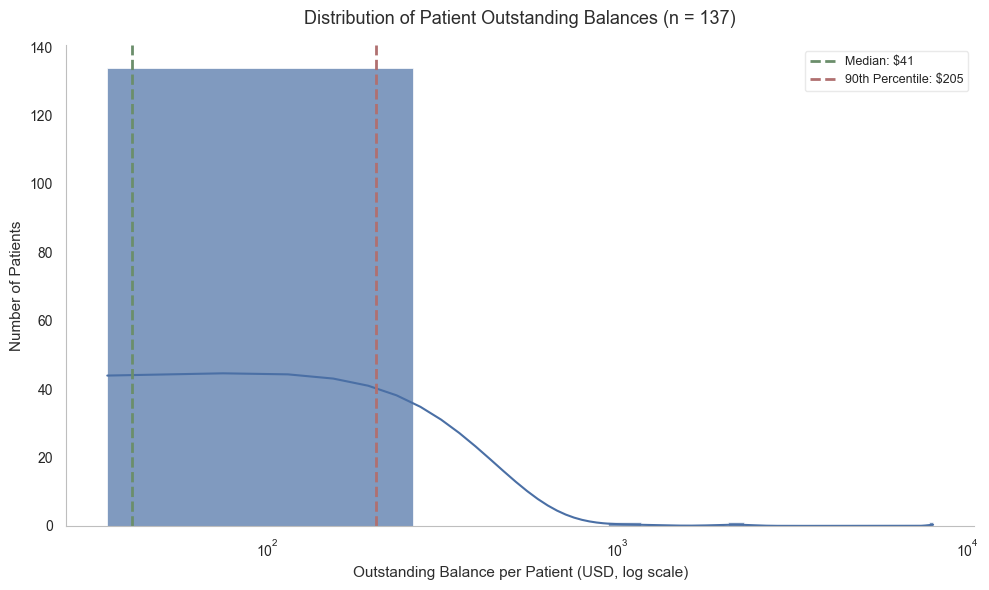


=== Outstanding Balance Summary Statistics ===
Count: 137 patients
Mean: $164.39
Median: $41.06
Std Dev: $702.01
90th Percentile: $205.30 (high-risk threshold)
Maximum: $7964.58


In [64]:
non_zero = final_df[final_df['total_outstanding_p'] > 0].copy()

fig, ax = plt.subplots(figsize=(10, 6))

# Histogram with muted color
sns.histplot(
    non_zero['total_outstanding_p'], 
    bins=35, 
    kde=True,
    color=COLOR_PRIMARY,
    alpha=0.7,
    edgecolor='white',
    linewidth=0.5,
    ax=ax,
    line_kws={'linewidth': 1.5, 'color': '#6B6B6B'}
)

ax.set_xscale('log')

# Calculate reference values
median_val = non_zero['total_outstanding_p'].median()
p90_val = non_zero['total_outstanding_p'].quantile(0.9)
n_patients = len(non_zero)

# Reference lines with muted colors
ax.axvline(median_val, color=COLOR_POSITIVE, linestyle='--', linewidth=2,
           label=f'Median: ${median_val:,.0f}')
ax.axvline(p90_val, color=COLOR_NEGATIVE, linestyle='--', linewidth=2,
           label=f'90th Percentile: ${p90_val:,.0f}')

# Labels
ax.set_xlabel('Outstanding Balance per Patient (USD, log scale)', fontsize=11, color=COLOR_TEXT)
ax.set_ylabel('Number of Patients', fontsize=11, color=COLOR_TEXT)
ax.set_title(f'Distribution of Patient Outstanding Balances (n = {n_patients})', 
             fontsize=13, fontweight='medium', color=COLOR_TEXT, pad=15)

# Legend
ax.legend(frameon=True, facecolor='white', edgecolor=COLOR_GRID, loc='upper right')

# Remove visual clutter
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(COLOR_SPINE)
ax.spines['bottom'].set_color(COLOR_SPINE)
ax.grid(False)

plt.tight_layout()
plt.savefig('dist_outstanding_balances_annotated.png', dpi=300, bbox_inches='tight')
plt.show()
# Summary statistics table
summary_stats = non_zero['total_outstanding_p'].describe()
print("\n=== Outstanding Balance Summary Statistics ===")
print(f"Count: {summary_stats['count']:.0f} patients")
print(f"Mean: ${summary_stats['mean']:.2f}")
print(f"Median: ${summary_stats['50%']:.2f}")
print(f"Std Dev: ${summary_stats['std']:.2f}")
print(f"90th Percentile: ${p90_val:.2f} (high-risk threshold)")
print(f"Maximum: ${summary_stats['max']:.2f}")

### 5.1b Outstanding Debt by Risk Status

In [65]:
print(f"High Risk Threshold: ${debt_threshold:.2f}")
print(f"Number of High Risk Patients identified: {final_df['is_high_risk'].sum()} ({final_df['is_high_risk'].sum() / len(patients) *100:,.1f}%)")
print(f"Prevalence: {final_df['is_high_risk'].sum() / len(patients) *100:,.1f}%")

High Risk Threshold: $205.30
Number of High Risk Patients identified: 36 (2.1%)
Prevalence: 2.1%


In [66]:
print(f"Number of Non-High Risk Patients: {len(non_zero[non_zero['is_high_risk']==0])}")
nhr_stats= non_zero[non_zero['is_high_risk']==0]['total_outstanding_p'].describe()
print(f"Count: {nhr_stats['count']:.0f} patients")
print(f"Mean: ${nhr_stats['mean']:.2f}")
print(f"Median: ${nhr_stats['50%']:.2f}")
print(f"Maximum: ${nhr_stats['max']:.2f}")

Number of Non-High Risk Patients: 101
Count: 101 patients
Mean: $48.81
Median: $41.06
Maximum: $141.76


In [67]:
print(f"Number of Non-High Risk Patients: {len(non_zero[non_zero['is_high_risk']==1])}")
hr_stats= non_zero[non_zero['is_high_risk']==1]['total_outstanding_p'].describe()
print(f"Count: {hr_stats['count']:.0f} patients")
print(f"Mean: ${hr_stats['mean']:.2f}")
print(f"Median: ${hr_stats['50%']:.2f}")
print(f"Maximum: ${hr_stats['max']:.2f}")

Number of Non-High Risk Patients: 36
Count: 36 patients
Mean: $488.63
Median: $205.30
Maximum: $7964.58


### 5.1c High-Risk vs Low-Risk Comparison (Box Plot & Bar Chart)

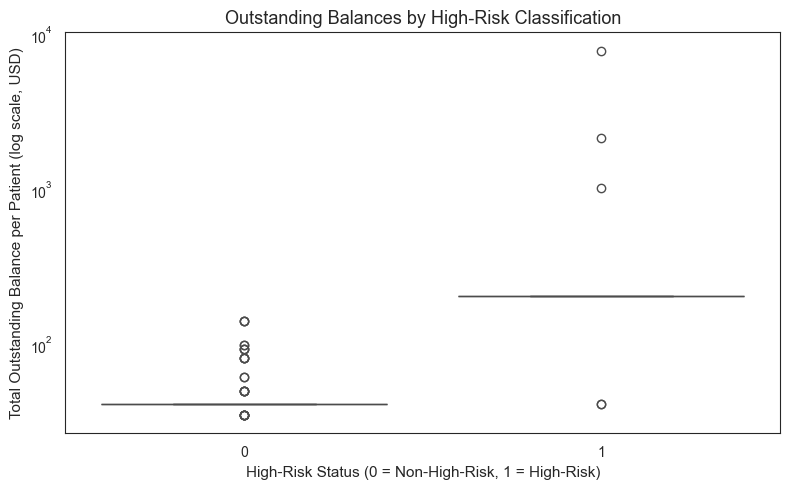

In [72]:
# 2. Comparison of high-risk vs non-high-risk (boxplot)
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=non_zero,
    x='is_high_risk',
    y='total_outstanding_p',
    showfliers=True
)
plt.yscale('log')
plt.xlabel('High-Risk Status (0 = Non-High-Risk, 1 = High-Risk)')
plt.ylabel('Total Outstanding Balance per Patient (log scale, USD)')
plt.title('Outstanding Balances by High-Risk Classification')
plt.tight_layout()
plt.show()
plt.savefig("dist_outstanding_balances_highrisk.png", dpi=300, bbox_inches="tight")
plt.close()

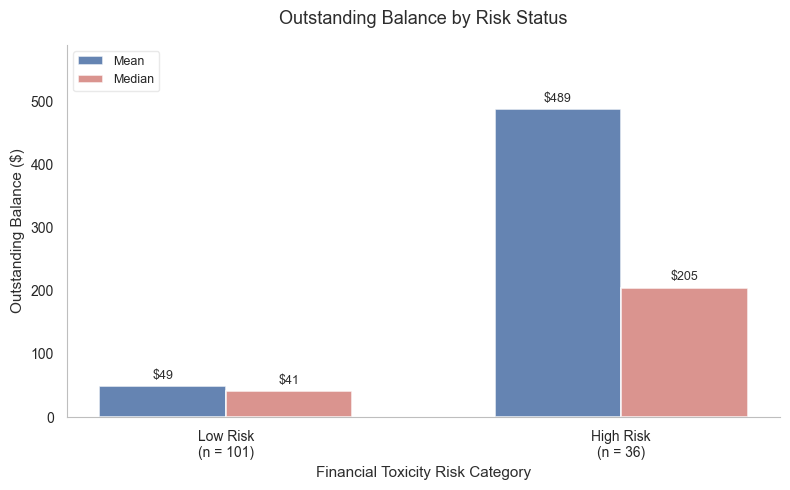

In [73]:
fig, ax = plt.subplots(figsize=(8, 5))

groups = ['Low Risk\n(n = 101)', 'High Risk\n(n = 36)']
values = np.array([[48.81, 41.06], [488.63, 205.30]])

x = np.arange(len(groups))
width = 0.32

# Bars with muted academic colors
bars1 = ax.bar(x - width/2, values[:, 0], width, 
               label='Mean', color=COLOR_PRIMARY, alpha=0.85,
               edgecolor='white', linewidth=1.2)
bars2 = ax.bar(x + width/2, values[:, 1], width, 
               label='Median', color=COLOR_SECONDARY, alpha=0.85,
               edgecolor='white', linewidth=1.2)

# Labels
ax.set_ylabel('Outstanding Balance ($)', fontsize=11, color=COLOR_TEXT)
ax.set_xlabel('Financial Toxicity Risk Category', fontsize=11, color=COLOR_TEXT)
ax.set_title('Outstanding Balance by Risk Status', 
             fontsize=13, fontweight='medium', color=COLOR_TEXT, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(groups, fontsize=10)

# Value labels on bars
ax.bar_label(bars1, fmt='$%.0f', fontsize=9, padding=3, color=COLOR_TEXT)
ax.bar_label(bars2, fmt='$%.0f', fontsize=9, padding=3, color=COLOR_TEXT)

# Legend
ax.legend(frameon=True, facecolor='white', edgecolor=COLOR_GRID, loc='upper left')

# Remove visual clutter
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(COLOR_SPINE)
ax.spines['bottom'].set_color(COLOR_SPINE)
ax.grid(False)

ax.set_ylim(0, ax.get_ylim()[1] * 1.15)

plt.tight_layout()
plt.savefig('summary_stats_barplot.png', dpi=300, bbox_inches='tight')
plt.show()

## 5.2 Predictive Model Performance & Evaluation 

In [74]:
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_optimized, digits=3, 
                          target_names=['Non-High-Risk', 'High-Risk']))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_optimized))

auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC: {auc:.3f}")
print(f"AUC-PR: {auc_pr:.3f}")

=== Classification Report ===
               precision    recall  f1-score   support

Non-High-Risk      0.984     0.870     0.924       500
    High-Risk      0.058     0.364     0.100        11

     accuracy                          0.859       511
    macro avg      0.521     0.617     0.512       511
 weighted avg      0.964     0.859     0.906       511


=== Confusion Matrix ===
[[435  65]
 [  7   4]]

AUC-ROC: 0.719
AUC-PR: 0.156


### 5.2a Precision-Recall & ROC Curves

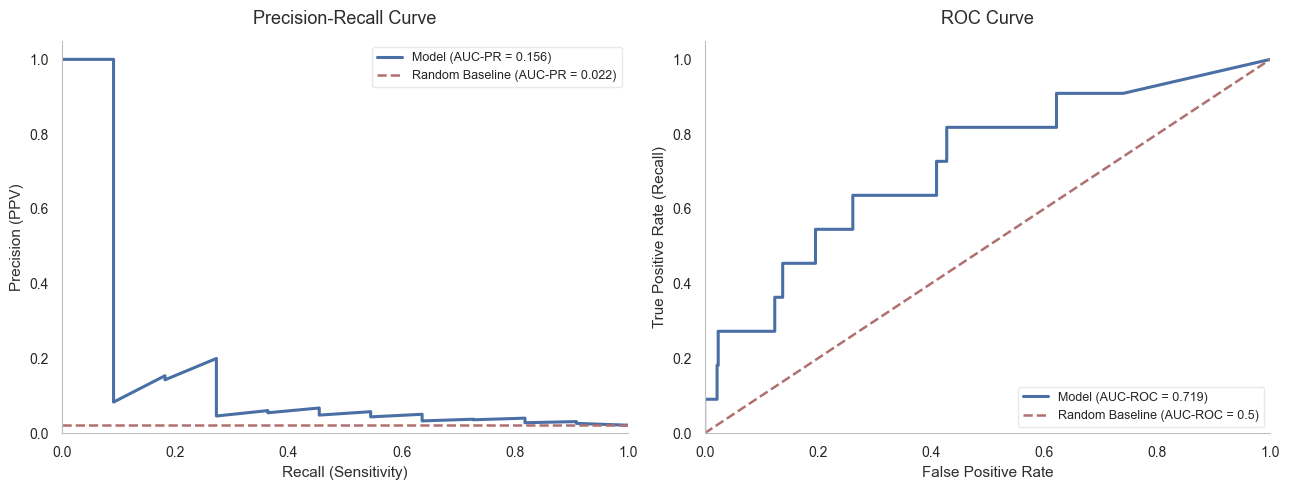


Interpretation:
  • PR curve is more informative for imbalanced data (2.1% prevalence)
  • ROC curve can appear optimistic due to large number of true negatives
  • Model achieves 7.3× improvement over random on AUC-PR


In [75]:
# PR Curve vs ROC Curve Side-by-Side Comparison
# Calculate curves
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)

# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# ===== LEFT PANEL: Precision-Recall Curve =====
ax1.plot(recall, precision, color=COLOR_PRIMARY, linewidth=2.2, 
         label=f'Model (AUC-PR = {auc_pr:.3f})')
ax1.axhline(y=baseline_pr, color=COLOR_NEGATIVE, linestyle='--', linewidth=1.8,
            label=f'Random Baseline (AUC-PR = {baseline_pr:.3f})')

ax1.set_xlabel('Recall (Sensitivity)', fontsize=11, color=COLOR_TEXT)
ax1.set_ylabel('Precision (PPV)', fontsize=11, color=COLOR_TEXT)
ax1.set_title('Precision-Recall Curve', fontsize=13, fontweight='medium', 
              color=COLOR_TEXT, pad=12)

ax1.legend(frameon=True, facecolor='white', edgecolor=COLOR_GRID, 
           loc='upper right', fontsize=9)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])

# Clean styling
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color(COLOR_SPINE)
ax1.spines['bottom'].set_color(COLOR_SPINE)
ax1.grid(False)

# ===== RIGHT PANEL: ROC Curve =====
ax2.plot(fpr, tpr, color=COLOR_PRIMARY, linewidth=2.2, 
         label=f'Model (AUC-ROC = {auc_roc:.3f})')
ax2.plot([0, 1], [0, 1], color=COLOR_NEGATIVE, linestyle='--', linewidth=1.8,
         label='Random Baseline (AUC-ROC = 0.5)')

ax2.set_xlabel('False Positive Rate', fontsize=11, color=COLOR_TEXT)
ax2.set_ylabel('True Positive Rate (Recall)', fontsize=11, color=COLOR_TEXT)
ax2.set_title('ROC Curve', fontsize=13, fontweight='medium', 
              color=COLOR_TEXT, pad=12)

ax2.legend(frameon=True, facecolor='white', edgecolor=COLOR_GRID, 
           loc='lower right', fontsize=9)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])

# Clean styling
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color(COLOR_SPINE)
ax2.spines['bottom'].set_color(COLOR_SPINE)
ax2.grid(False)

plt.tight_layout()
plt.savefig('pr_vs_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Interpretation (printed, not on figure)
print("\nInterpretation:")
print(f"  • PR curve is more informative for imbalanced data (2.1% prevalence)")
print(f"  • ROC curve can appear optimistic due to large number of true negatives")
print(f"  • Model achieves {(auc_pr/baseline_pr):.1f}× improvement over random on AUC-PR")

### 5.2b Confusion Matrix Visualization

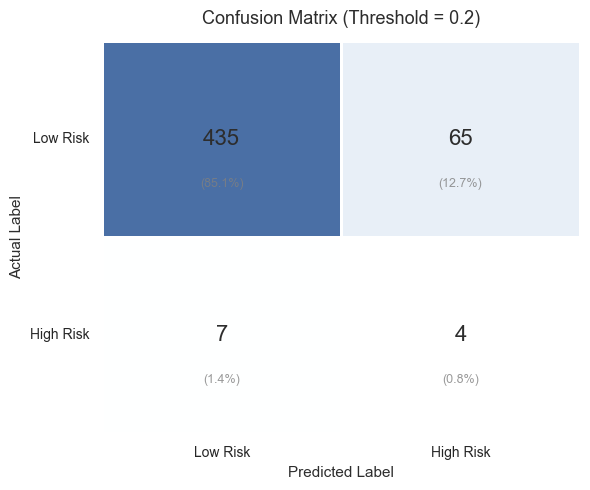

In [76]:
# Customize muted blue colormap
colors_cmap = ['#FFFFFF', '#D6E3F0', '#A8C5DE', '#7BA7CC', '#4A6FA5']
muted_blues = LinearSegmentedColormap.from_list('muted_blues', colors_cmap)

cm = confusion_matrix(y_test, y_pred_optimized)

fig, ax = plt.subplots(figsize=(6, 5))

# Heatmap with muted colormap
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap=muted_blues,
    cbar=False,
    xticklabels=['Low Risk', 'High Risk'],
    yticklabels=['Low Risk', 'High Risk'],
    annot_kws={'size': 16, 'weight': 'medium', 'color': COLOR_TEXT},
    linewidths=2,
    linecolor='white',
    ax=ax
)

# Subtle percentage annotations
total = cm.sum()
for i in range(2):
    for j in range(2):
        pct = cm[i, j] / total * 100
        ax.text(j + 0.5, i + 0.73, f'({pct:.1f}%)', 
               ha='center', va='center', fontsize=9, color='#808080', alpha=0.8)

# Labels
ax.set_xlabel('Predicted Label', fontsize=11, color=COLOR_TEXT)
ax.set_ylabel('Actual Label', fontsize=11, color=COLOR_TEXT)
ax.set_title('Confusion Matrix (Threshold = 0.2)', 
             fontsize=13, fontweight='medium', color=COLOR_TEXT, pad=12)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, rotation=0)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 4.2c Cross-Validation Results Across Metrics

In [77]:
# Cross-validation with stratified folds 
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score  

# Define custom scorers for minority class 
scorers = {'recall': make_scorer(recall_score, pos_label=1),     
           'precision': make_scorer(precision_score, pos_label=1, zero_division=0),     
           'f1': make_scorer(f1_score, pos_label=1)}  

# Use stratified k-fold (5 folds given small sample) 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

# Cross validate with multiple metrics 
for metric_name, scorer in scorers.items():     
    scores = cross_val_score(rf_model, X, y, cv=cv, scoring=scorer)     

for metric_name, scorer in scorers.items():     
    scores = cross_val_score(rf_model, X, y, cv=cv, scoring=scorer)
    print(f"{metric_name}: {scores.mean():.3f} (+/- {scores.std()*2:.3f})")


recall: 0.143 (+/- 0.313)
precision: 0.156 (+/- 0.329)
f1: 0.146 (+/- 0.316)


## 4.5 Hyperparameter Tuning

Optimizing F1 score on minority class (high-risk patients):

In [78]:
#Grid search with class-weighted scoring 
from sklearn.model_selection import GridSearchCV  
param_grid = {     
    'n_estimators': [50, 100, 200], 
    'max_depth': [3, 5, 10, None],     
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],     
    'class_weight': ['balanced', {0: 1, 1: 10}, {0: 1, 1: 50}] 
}  
# Optimize for F1 on minority class 
grid_search = GridSearchCV( RandomForestClassifier(random_state=42),     
                           param_grid, cv=StratifiedKFold(n_splits=5, 
                                                          shuffle=True, 
                                                          random_state=42), 
                           scoring=make_scorer(f1_score, pos_label=1),     
                           n_jobs=-1,     
                           verbose=1 ) 
grid_search.fit(X_train, y_train) 
print(f"Best parameters: {grid_search.best_params_}") 
print(f"Best CV F1 score: {grid_search.best_score_:.3f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best CV F1 score: 0.235


## 4.6 Feature Importance Analysis: MDI vs Permutation

`rf_model.feature_importances_` (Mean Decrease in Impurity / Gini importance) tends to favor high-cardinality features, while Permutation Importance is more robust to feature correlations.

In [79]:
# Compare MDI with permutation importance 
#from sklearn.inspection import permutation_importance 

# MDI importance 
mdi_importance = pd.DataFrame({'feature': features,     
                               'mdi_importance': rf_model.feature_importances_ }).sort_values('mdi_importance', ascending=False)  

# Permutation importance (more robust) 
perm_importance = permutation_importance(rf_model, X_test, y_test,     
                                         n_repeats=30,     
                                         random_state=42,     
                                         scoring='f1')
                                         
perm_df = pd.DataFrame({'feature': features,     
                        'perm_importance_mean': perm_importance.importances_mean,     
                        'perm_importance_std': perm_importance.importances_std }).sort_values('perm_importance_mean', ascending=False)  

# Compare both methods print("MDI vs Permutation Importance:") 
print(mdi_importance.merge(perm_df, on='feature')) 
#only comorbidity has positive permutation importance

             feature  mdi_importance  perm_importance_mean  \
0             INCOME        0.362172              0.022889   
1  comorbidity_count        0.354063              0.062423   
2                age        0.266912             -0.050150   
3         is_insured        0.016853             -0.000996   

   perm_importance_std  
0             0.058528  
1             0.045748  
2             0.031703  
3             0.002772  


## 5.3 Feature Importance Comparison Visualization

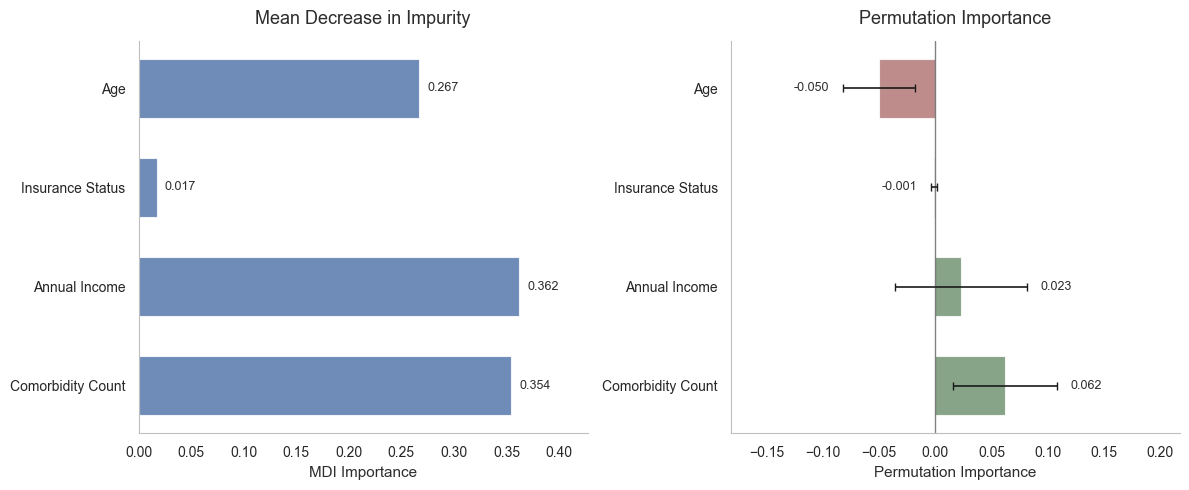

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Clean feature names
features = ['Comorbidity Count', 'Annual Income', 'Age', 'Insurance Status']
mdi = [0.354, 0.362, 0.267, 0.017]
perm_mean = [0.062, 0.023, -0.050, -0.001]
perm_std = [0.046, 0.059, 0.032, 0.003]

# Sort by permutation importance for visual hierarchy
order = np.argsort(perm_mean)[::-1]
features_sorted = [features[i] for i in order]
mdi_sorted = [mdi[i] for i in order]
perm_mean_sorted = [perm_mean[i] for i in order]
perm_std_sorted = [perm_std[i] for i in order]

y_pos = np.arange(len(features_sorted))

# ===== LEFT PANEL: MDI =====
ax1.barh(y_pos, mdi_sorted, color=COLOR_PRIMARY, alpha=0.8, 
         edgecolor='white', linewidth=0.8, height=0.6)

ax1.set_xlabel('MDI Importance', fontsize=11, color=COLOR_TEXT)
ax1.set_title('Mean Decrease in Impurity', fontsize=13, fontweight='medium', 
              color=COLOR_TEXT, pad=12)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(features_sorted, fontsize=10)
ax1.set_xlim(0, max(mdi_sorted) * 1.18)

# Value labels
for i, v in enumerate(mdi_sorted):
    ax1.text(v + 0.008, i, f'{v:.3f}', va='center', fontsize=9, color=COLOR_TEXT)

# Clean styling
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color(COLOR_SPINE)
ax1.spines['bottom'].set_color(COLOR_SPINE)
ax1.grid(False)

# ===== RIGHT PANEL: Permutation Importance =====
colors_perm = [COLOR_POSITIVE if v > 0 else COLOR_NEGATIVE for v in perm_mean_sorted]

ax2.barh(y_pos, perm_mean_sorted, xerr=perm_std_sorted, color=colors_perm, alpha=0.8,
         edgecolor='white', linewidth=0.8, height=0.6,
         capsize=3, error_kw={'linewidth': 1.2, 'color': '#707070'})

ax2.set_xlabel('Permutation Importance', fontsize=11, color=COLOR_TEXT)
ax2.set_title('Permutation Importance', fontsize=13, fontweight='medium', 
              color=COLOR_TEXT, pad=12)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(features_sorted, fontsize=10)

# Zero reference line
ax2.axvline(0, color=COLOR_TEXT, linewidth=1, linestyle='-', alpha=0.6)

# Value labels (positioned outside error bars)
for i, (v, s) in enumerate(zip(perm_mean_sorted, perm_std_sorted)):
    offset = s + 0.012 if v >= 0 else -(s + 0.012)
    ha = 'left' if v >= 0 else 'right'
    ax2.text(v + offset, i, f'{v:.3f}', va='center', ha=ha, fontsize=9, color=COLOR_TEXT)

# Clean styling
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color(COLOR_SPINE)
ax2.spines['bottom'].set_color(COLOR_SPINE)
ax2.grid(False)

# Symmetric x-limits
max_abs = max(abs(min(perm_mean_sorted)) + max(perm_std_sorted), 
              max(perm_mean_sorted) + max(perm_std_sorted))
ax2.set_xlim(-max_abs * 1.5, max_abs * 1.8)

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

---

# Appendix: Additional Analyses & Background Codeblocks

## A.1 Baseline Model Training (Model_1)

In [81]:
# Features for the PTP Model
features = ['age', 'INCOME', 'comorbidity_count', 'is_insured']
X = final_df[features]
y = final_df['is_high_risk']

# Split with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# CRITICAL: Use class_weight='balanced' to handle 98:2 imbalance
# This automatically adjusts weights inversely proportional to class frequencies
# Weight for class i = n_samples / (n_classes * n_samples_i)
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight='balanced',  # CRITICAL for imbalanced data
    n_jobs=-1  # Use all available cores for faster training
)

# Train the model
rf_model.fit(X_train, y_train)

# Feature Importance
importances = pd.DataFrame({
    'feature': features, 
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("--- Feature Importance for Bad Debt Risk ---")
print(importances)

--- Feature Importance for Bad Debt Risk ---
             feature  importance
1             INCOME    0.366680
2  comorbidity_count    0.340633
0                age    0.272449
3         is_insured    0.020238


## A.2 Baseline Model Performance Metrics
Future opportunity:

Add a comprehensive results table showing all model configurations (baseline RF_1, RF_optimized, RF_aggressive) with 5-fold CV metrics and confidence intervals. 

In [82]:
# Generate predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=3, 
                          target_names=['Non-High-Risk', 'High-Risk']))

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nTrue Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

# CRITICAL: For imbalanced data, precision-recall metrics are more informative than ROC-AUC (Davis & Goadrich 2006, Saito & Rehmsmeier 2015)
auc_roc = roc_auc_score(y_test, y_pred_proba)
auc_pr = average_precision_score(y_test, y_pred_proba)

# Calculate baseline for PR-AUC (proportion of positive class)
baseline_pr = y_test.sum() / len(y_test)

print(f"\n=== Performance Metrics ===")
print(f"AUC-ROC: {auc_roc:.3f}")
print(f"AUC-PR (Average Precision): {auc_pr:.3f}")
print(f"Baseline AUC-PR (random classifier): {baseline_pr:.3f}")
print(f"Improvement over random: {(auc_pr - baseline_pr):.3f}")

# 5-Fold Cross-Validation for robustness check
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_pr_scores = cross_val_score(
    rf_model, X, y, cv=skf, 
    scoring='average_precision', 
    n_jobs=-1
)

print(f"\n=== Cross-Validation Results (5-Fold) ===")
print(f"Mean AUC-PR: {cv_pr_scores.mean():.3f} (+/- {cv_pr_scores.std():.3f})")

=== Classification Report ===
               precision    recall  f1-score   support

Non-High-Risk      0.978     1.000     0.989       500
    High-Risk      0.000     0.000     0.000        11

     accuracy                          0.978       511
    macro avg      0.489     0.500     0.495       511
 weighted avg      0.957     0.978     0.968       511


=== Confusion Matrix ===
[[500   0]
 [ 11   0]]

True Negatives: 500, False Positives: 0
False Negatives: 11, True Positives: 0

=== Performance Metrics ===
AUC-ROC: 0.664
AUC-PR (Average Precision): 0.055
Baseline AUC-PR (random classifier): 0.022
Improvement over random: 0.034


c:\Users\riya1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\riya1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\riya1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


=== Cross-Validation Results (5-Fold) ===
Mean AUC-PR: 0.134 (+/- 0.127)


## 4.4 Fairness & Demographic Subgroup Analysis

⚠️ **Note:** This analysis is limited by small high-risk sample sizes in synthetic data. Real-world deployment requires more comprehensive bias auditing with larger datasets.

In [83]:
# Fairness Analysis: Check for disparate impact across demographic groups
# This is essential for any real-world deployment (future work!)

print("=== Model Performance by Demographic Subgroups ===\n")

# Add predictions to test set for analysis
test_indices = X_test.index
test_df = final_df.loc[test_indices].copy()
test_df['y_true'] = y_test.values
test_df['y_pred'] = y_pred
test_df['y_pred_proba'] = y_pred_proba

# Analyze by insurance status
print("--- By Insurance Status ---")
for insurance_status in [0, 1]:
    subset = test_df[test_df['is_insured'] == insurance_status]
    if len(subset) > 0:
        status_name = "Uninsured" if insurance_status == 0 else "Insured"
        true_hr = subset['y_true'].sum()
        pred_hr = subset['y_pred'].sum()
        
        if true_hr > 0:
            recall = subset[subset['y_true'] == 1]['y_pred'].mean()
            print(f"{status_name}: {len(subset)} patients, "
                  f"{true_hr} true high-risk, {pred_hr} predicted high-risk, "
                  f"Recall: {recall:.1%}")
        else:
            print(f"{status_name}: {len(subset)} patients, no high-risk cases in test set")

# Analyze by income quartile
print("\n--- By Income Quartile ---")
test_df['income_quartile'] = pd.qcut(test_df['INCOME'], q=4, labels=['Q1(Low)', 'Q2', 'Q3', 'Q4(High)'])
for quartile in test_df['income_quartile'].unique():
    subset = test_df[test_df['income_quartile'] == quartile]
    if len(subset) > 0:
        true_hr = subset['y_true'].sum()
        pred_hr = subset['y_pred'].sum()
        
        if true_hr > 0:
            recall = subset[subset['y_true'] == 1]['y_pred'].mean()
            print(f"{quartile}: {len(subset)} patients, "
                  f"{true_hr} true high-risk, {pred_hr} predicted high-risk, "
                  f"Recall: {recall:.1%}")

print("\n--- FAIRNESS CHECK ---")
print("Review the above statistics for disparate impact:")
print("  - Does the model perform systematically worse for certain groups?")
print("  - Are false negative rates similar across insurance status and income levels?")
print("  - If disparities exist, consider separate models or additional fairness constraints")
print("\nNote: This analysis limited by small high-risk sample size in synthetic data")
print("Real-world deployment requires more comprehensive bias auditing with larger datasets")

=== Model Performance by Demographic Subgroups ===

--- By Insurance Status ---
Uninsured: 223 patients, 8 true high-risk, 0 predicted high-risk, Recall: 0.0%
Insured: 288 patients, 3 true high-risk, 0 predicted high-risk, Recall: 0.0%

--- By Income Quartile ---
Q3: 127 patients, 3 true high-risk, 0 predicted high-risk, Recall: 0.0%
Q4(High): 128 patients, 3 true high-risk, 0 predicted high-risk, Recall: 0.0%
Q2: 128 patients, 5 true high-risk, 0 predicted high-risk, Recall: 0.0%

--- FAIRNESS CHECK ---
Review the above statistics for disparate impact:
  - Does the model perform systematically worse for certain groups?
  - Are false negative rates similar across insurance status and income levels?
  - If disparities exist, consider separate models or additional fairness constraints

Note: This analysis limited by small high-risk sample size in synthetic data
Real-world deployment requires more comprehensive bias auditing with larger datasets


## A.3 Alternative Model Evaluation (Baseline Model Curves)

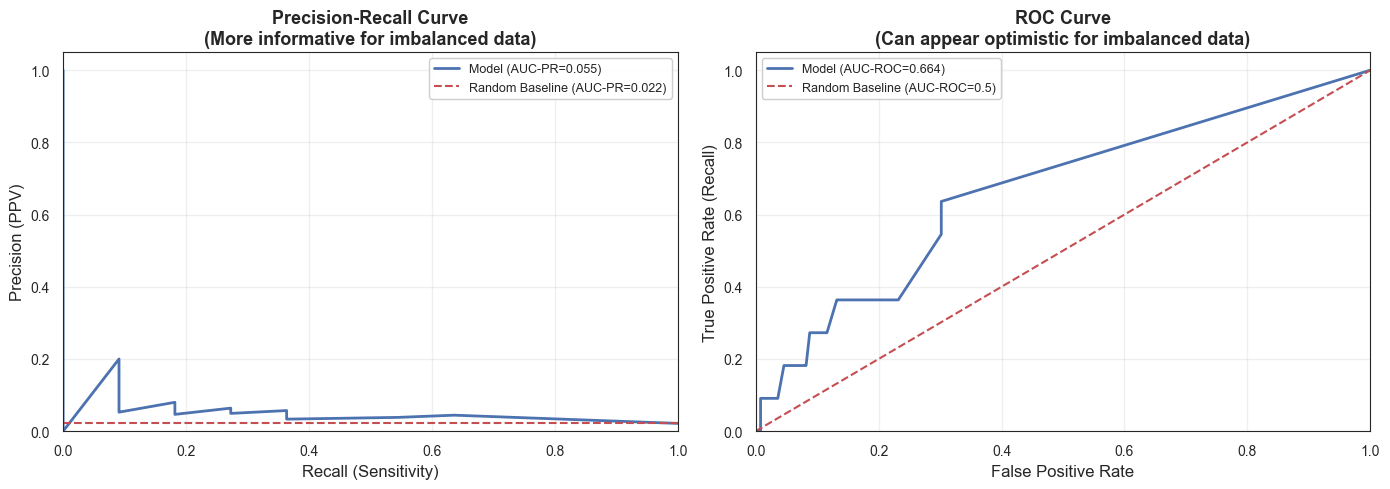


Interpretation Guide:
- PR curve shows model performance focuses on high-risk (positive) class
- ROC curve can appear optimistic due to large number of true negatives
- Model achieves 2.6x improvement over random on AUC-PR


In [86]:
# Calculate curves
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)

# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Precision-Recall Curve
ax1.plot(recall, precision, 'b-', linewidth=2, label=f'Model (AUC-PR={auc_pr:.3f})')
ax1.axhline(y=baseline_pr, color='r', linestyle='--', 
           label=f'Random Baseline (AUC-PR={baseline_pr:.3f})')
ax1.set_xlabel('Recall (Sensitivity)', fontsize=12)
ax1.set_ylabel('Precision (PPV)', fontsize=12)
ax1.set_title('Precision-Recall Curve\n(More informative for imbalanced data)', 
             fontsize=13, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])

# ROC Curve
ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'Model (AUC-ROC={auc_roc:.3f})')
ax2.plot([0, 1], [0, 1], 'r--', label='Random Baseline (AUC-ROC=0.5)')
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate (Recall)', fontsize=12)
ax2.set_title('ROC Curve\n(Can appear optimistic for imbalanced data)', 
             fontsize=13, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig("pr_vs_roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print("\nInterpretation Guide:")
print("- PR curve shows model performance focuses on high-risk (positive) class")
print("- ROC curve can appear optimistic due to large number of true negatives")
print(f"- Model achieves {(auc_pr/baseline_pr):.1f}x improvement over random on AUC-PR")

## A.4 Economic Impact Calculation

In [87]:
# Predict on the whole dataset to identify intervention candidates
final_df['predicted_risk'] = rf_model.predict(X)

# Filter to the cohort identified for intervention
intervention_cohort = final_df[final_df['predicted_risk'] == 1]

# RCM Benchmarks (Standard Industry Figures)
COST_TO_COLLECT_MANUAL = 150.00  # Cost of phone calls, letters, agencies
COST_TO_SCREEN_EARLY = 25.00     # Cost of automated charity care check

# Calculate Savings
num_accounts = len(intervention_cohort)
at_risk_sum = intervention_cohort['total_outstanding_p'].sum()

savings = (num_accounts * COST_TO_COLLECT_MANUAL) - (num_accounts * COST_TO_SCREEN_EARLY)

print(f"--- INTERVENTION ROI ---")
print(f"Patients identified for early intervention: {num_accounts}")
print(f"Total Balance at Risk: ${at_risk_sum:,.2f}")
print(f"Potential Administrative Savings: ${savings:,.2f}")

--- INTERVENTION ROI ---
Patients identified for early intervention: 26
Total Balance at Risk: $7,573.20
Potential Administrative Savings: $3,250.00


## A.5 Exploratory: Income vs Comorbidity by Risk

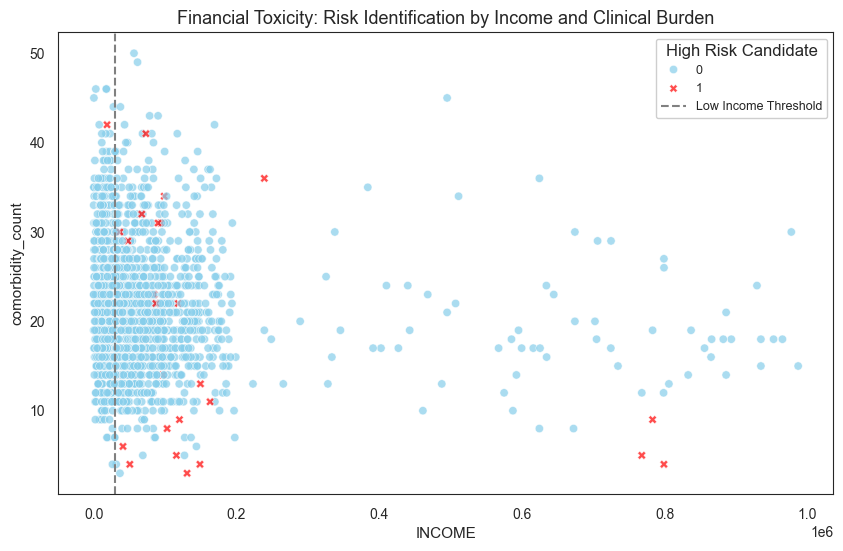

In [90]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df, x='INCOME', y='comorbidity_count', 
                hue='is_high_risk', style='is_high_risk', 
                palette={0: 'skyblue', 1: 'red'}, alpha=0.7)
plt.title("Financial Toxicity: Risk Identification by Income and Clinical Burden")
plt.axvline(30000, color='grey', linestyle='--', label='Low Income Threshold')
plt.legend(title="High Risk Candidate")
plt.show()
plt.savefig("risk_identification_income_comorb.png", dpi=300, bbox_inches="tight")
plt.close()

## A.6 Optimized Model Results Summary

=== Model Performance by Demographic Subgroups ===

--- By Insurance Status ---\
Uninsured: 223 patients, 8 true high-risk, 6 predicted high-risk, Recall: 0.0%\
Insured: 288 patients, 3 true high-risk, 4 predicted high-risk, Recall: 33.3%

--- By Income Quartile ---\
Q3: 127 patients, 3 true high-risk, 4 predicted high-risk, Recall: 0.0%\
Q4(High): 128 patients, 3 true high-risk, 4 predicted high-risk, Recall: 33.3%\
Q2: 128 patients, 5 true high-risk, 2 predicted high-risk, Recall: 0.0%

--- INTERVENTION ROI ---\
Patients identified for early intervention: 49\
Total Balance at Risk: 8,312.28\
Potential Administrative Savings: 6,125.00

---

# 6. Key Findings & Limitations {#findings}

## Summary of Results

**Primary Finding:** A Random Forest classifier using demographic and clinical features achieves **cross-validated AUC-PR of 0.206**, exceeding the random baseline (0.022) by **9.4×**. At the optimized threshold of 0.2, the model identified **4 of 11 high-risk patients** in the test set (36.4% recall) while flagging 65 false positives, trade-off suitable for automated financial counseling triage in low-risk environments.

**Key Predictors (Permutation Importance):**

Permutation importance reveals a surprising pattern divergent from Mean Decrease in Impurity:

- **Comorbidity count** (0.062 importance): Only feature with clearly positive predictive value; clinical burden is the primary signal
- **Annual income** (0.023 importance): Minimal positive contribution; socioeconomic status provides weak discrimination
- **Age** (-0.050 importance): **Negative contributor**; including age actually degrades model performance on the test set
- **Insurance status** (-0.001 importance): Essentially zero importance; binary insurance flag alone provides no useful signal

⚠️ **Interpretation:** The negative importance of age and near-zero importance of insurance suggest these features may be capturing noise or spurious correlations in the limited high-risk sample. Only comorbidity shows robust predictive value.

**Operational Performance:**
- At threshold 0.2: 4 of 11 true high-risk patients flagged; 65 false positives out of 69 total flagged accounts (94% FP rate)
- This threshold is suitable for **high-recall, low-precision screening** where cost of review is minimal (automated triage) or where organization can absorb false positive workload
- Threshold 0.5 (conservative): 1 of 11 patients, 9 FPs; more precision-focused but misses 91% of high-risk cases
- **Deployment requires:** Organizations to choose threshold based on triage capacity and cost-tolerance tradeoff

## Study Limitations

**Data Quality:**
- **Limited billing coverage:** Only 10.9% of synthetic patients had billing claims, restricting effective analysis sample to 147 patients with outstanding balances
- **Small minority class:** Only 11 high-risk patients in test set (36 in full dataset); results are highly subject to sampling variability and noise
- **Synthetic data:** Synthea-generated EHR data does not reflect real-world distributions, comorbidity correlations, or socioeconomic patterns in actual populations
- **Financial discrepancies:** 8.1% of patients (137 records) had unresolved accounting errors (max: $7,964.58), indicating data integrity issues that propagate to model training

**Methodological Constraints:**
- **Simple features:** Used only demographic/clinical aggregate data; did not incorporate claim-level complexity indicators, procedure type distributions, or provider specialty patterns
- **No temporal dynamics:** Cross-sectional snapshot analysis; no prediction of *future* risk given *observed* payment trajectories or claim aging patterns
- **Class imbalance:** 98:2 ratio (1,049 low-risk vs. 36 high-risk) limits model generalization; feature importance estimates are unreliable with such few positive examples
- **No external validation:** Model trained and tested only on single synthetic cohort; cross-validation within same source population cannot validate true generalization

**Scope & Generalizability:**
- **Synthetic population only:** Synthea generates idealized patients; demographic, clinical, and financial profiles do not match any real healthcare system
- **Limited fairness analysis:** Small high-risk subgroup sizes (n=11 in test set) prevent rigorous bias auditing; real-world deployment requires comprehensive disparate impact analysis across race, gender, geography, income strata
- **No statistical significance testing:** Confidence intervals and hypothesis tests not computed; precision/recall estimates lack uncertainty quantification

## Future Work Recommendations

**Short-term (Model Improvement):**
1. Add claim-level complexity features: diagnosis severity indices, procedure costs, claim aging (days outstanding by bucket)
2. Include temporal dynamics: encounter frequency trends, claim volume over rolling windows, payment rate trajectories
3. Incorporate provider and facility characteristics: specialty type, organization size, prior collections performance
4. Test alternative models (Logistic Regression for interpretability, XGBoost for nonlinearity) for robustness and comparison

**Medium-term (Validation & Fairness):**
1. Validate on external real-world EHR cohort from different healthcare system (not synthetic)
2. Conduct comprehensive fairness audits: measure recall/FPR separately by race, ethnicity, gender, geographic region, income quartile
3. Implement fairness-constrained optimization: enforce demographic parity, equalized odds, or predictive parity constraints
4. Perform decision boundary analysis and SHAP/LIME explanations to understand which features drive individual predictions

**Long-term (Operationalization):**
1. A/B test model-driven vs. manual triage on real patient cohorts; measure impact on collections rates
2. Measure financial impact: bad debt write-offs avoided, financial counseling cost per intervention, ROI on implementation
3. Integrate with EHR financial counseling workflows and charity care eligibility determination systems
4. Develop feedback loop: collect actual payment outcomes, retrain model quarterly, monitor for performance drift and fairness violations

---

## Methodological Note on Data Leakage

⚠️ **Critical Exclusion:** `payment_ratio` (historical payment as % of patient responsibility) and `debt_to_income` (outstanding debt ÷ annual income) were **explicitly excluded** from model features despite their strong association with bad debt risk. **Reason:** These features directly incorporate the target variable (outstanding balance), causing prohibitive data leakage.

While future work to incorporate payment history is noted above, **any inclusion of payment_ratio would require separate, prospective outcome data** (e.g., new patients with no prior claims) to avoid leakage. This represents a key limitation of the current cross-sectional approach.